In [1]:
# Import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

In [2]:
# Read in data files
in_care_df = pd.read_csv("Data/in_care.txt", sep='\t')
adopted_df = pd.read_csv("Data/adopted.txt", sep='\t')
tpr_df = pd.read_csv("Data/tpr.txt", sep='\t')

In [3]:
in_care_df.head()

,State,FY 2010,FY 2011,FY 2012,FY 2013,FY 2014,FY 2015,FY 2016,FY 2017,FY 2018,FY 2019
0,Alabama,5350.0,5253.0,4561.0,4435.0,4526.0,4745.0,5053.0,5631.0,5930.0,5783.0
1,Alaska,1791.0,1835.0,1854.0,1982.0,2190.0,2653.0,2824.0,2739.0,2781.0,2879.0
2,Arizona,9930.0,10883.0,13461.0,14399.0,16246.0,17738.0,17118.0,15031.0,13360.0,13330.0
3,Arkansas,3756.0,3732.0,3711.0,3797.0,3806.0,4548.0,4880.0,4776.0,4234.0,4127.0
4,California,56202.0,54754.0,54553.0,55383.0,56771.0,55983.0,54685.0,51869.0,52337.0,51268.0


## Clean DataFrame

In [4]:
# Keep only numerical data
years_df = in_care_df.drop(["State"], axis=1)

In [5]:
years_df.columns

Index(['FY 2010', 'FY 2011', 'FY 2012', 'FY 2013', 'FY 2014', 'FY 2015',
       'FY 2016', 'FY 2017', 'FY 2018', 'FY 2019'],
      dtype='object')

In [6]:
# Create list of years in dataset
years_list = []

for column in years_df.columns:
    year = column.split(" ")[1]
    years_list.append(int(year))

In [7]:
# Check shape 
years = np.array(years_list).reshape(-1,1)
years.shape

(10, 1)

In [8]:
# Store 
states = in_care_df["State"].values.tolist()

## Machine Learning

In [9]:
# Import dependencies
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [10]:
# Train and score model, then demonstrate predictive ability for all states

midwest = ['Illinois', 'Indiana', 'Iowa', 'Kansas', 'Michigan', 'Minnesota', 
           'Missouri', 'Nebraska', 'North Dakota', 'Ohio', 'South Dakota', 'Wisconsin']
plot_indexes = []

for index,row in years_df.iterrows():
    values = row.values.tolist()
    X = years
    y = values
    
    model = LinearRegression()

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    state = states[index]
    predicted = model.predict([[2025]])
    
    print(f"{state} Score: {score}")
    print(f"Prediction for 2025 In-Care: {predicted}")
    print("----------------------------")
    
    if (state in midwest) and score > .925:
        plot_indexes.append(index)

Alabama Score: 0.002620419823441411
Prediction for 2025 In-Care: [6112.95049505]
----------------------------
Alaska Score: 0.8763433482278176
Prediction for 2025 In-Care: [3868.26237624]
----------------------------
Arizona Score: 0.1728866052886493
Prediction for 2025 In-Care: [18299.01485149]
----------------------------
Arkansas Score: 0.3942158942444582
Prediction for 2025 In-Care: [5241.82673267]
----------------------------
California Score: 0.15128192247780614
Prediction for 2025 In-Care: [48684.37128713]
----------------------------
Colorado Score: 0.8856494887496643
Prediction for 2025 In-Care: [4404.50990099]
----------------------------
Connecticut Score: 0.18755574997130398
Prediction for 2025 In-Care: [3949.43069307]
----------------------------
Delaware Score: 0.2538390218400183
Prediction for 2025 In-Care: [605.93564356]
----------------------------
District of Columbia Score: 0.8810061028325079
Prediction for 2025 In-Care: [-339.29207921]
----------------------------
F

In [11]:
# Create DataFrame for plotting predictions of Midwestern states with model scores greater than 80%
plots_df = years_df.iloc[plot_indexes,:]

In [12]:
plots_df_final = plots_df.copy()

In [13]:
# Use model to 

predicted_years = [2020,2022,2024,2026,2028,2030]

for year in predicted_years:
    predictions = []
    for index,row in plots_df.iterrows():
        values = row.values.tolist()
        X = years
        y = values
        
        model = LinearRegression()
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
        model.fit(X_train, y_train)
        
        prediction = model.predict([[year]])
        predictions.append(prediction[0])

    plots_df_final[f"FY {year}"] = predictions

In [14]:
plots_df_final

,FY 2010,FY 2011,FY 2012,FY 2013,FY 2014,FY 2015,FY 2016,FY 2017,FY 2018,FY 2019,FY 2020,FY 2022,FY 2024,FY 2026,FY 2028,FY 2030
16,5979.0,5852.0,6002.0,6441.0,6762.0,7223.0,7302.0,7753.0,8068.0,8066.0,8361.269802,8885.571782,9409.873762,9934.175743,10458.477723,10982.779703
23,5063.0,5085.0,5330.0,5641.0,6324.0,7610.0,8793.0,9651.0,9271.0,8400.0,10011.722772,11082.495050,12153.267327,13224.039604,14294.811881,15365.584158
34,1078.0,1066.0,1109.0,1227.0,1365.0,1359.0,1407.0,1495.0,1576.0,1502.0,1612.700495,1720.695545,1828.690594,1936.685644,2044.680693,2152.675743
49,6575.0,6547.0,6384.0,6539.0,6918.0,7091.0,7382.0,7721.0,7819.0,7642.0,7936.314356,8264.170792,8592.027228,8919.883663,9247.740099,9575.596535


## Prediction

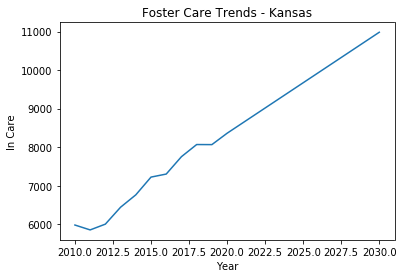

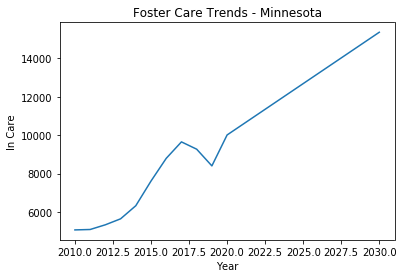

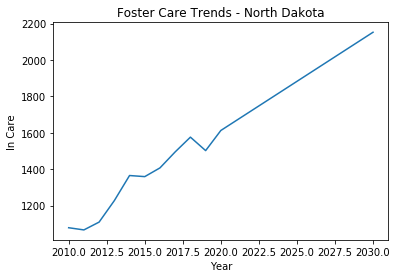

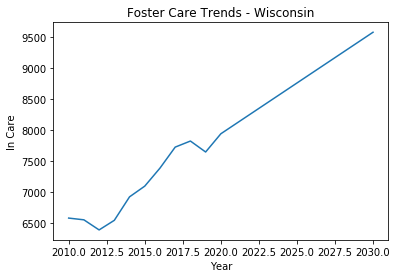

<Figure size 432x288 with 0 Axes>

In [15]:
for index,row in plots_df_final.iterrows():
    values = row.values.tolist()
    X = years_list + predicted_years
    y = values

    plt.plot(X, y)
    plt.xlabel("Year")
    plt.ylabel(f"In Care")
    plt.title(f"Foster Care Trends - {states[index]}")
    plt.show()
    
    plt.savefig(f"Images/{states[index]}_InCare.png")